In [1]:
import os 
import sys
while os.path.split(os.getcwd())[1] != 'RecSysChallenge2023-Team':
    os.chdir('..')
sys.path.insert(1, os.getcwd())

import numpy as np 

In [2]:
import random
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed=seed)


In [3]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

import Daniele.Utils.MyDataManager as dm 
import Daniele.Utils.MatrixManipulation as mm

URMv = dm.getURMviews()
URMo = dm.getURMopen()
ICMt=dm.getICMt()
ICMl=dm.getICMl()


URMv_train, URMv_test = split_train_in_two_percentage_global_sample(URMv, train_percentage = 0.80)


urm_def = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo,icml=ICMl,icmt=ICMt, normalize=True, add_aug=True,appendICM=True)
urm_bin = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo, normalize=False, add_aug=True)
urm_bin.data = np.ones(len(urm_bin.data))

path_save= "Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_models"

/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team


100%|██████████| 663370/663370 [00:00<00:00, 1814255.86it/s]


### SSLIIM

In [4]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
name="sslim01"
dir = os.path.join(path_save,name)

sslim_recommender = SLIM_BPR_Cython(URM_train=urm_def)
if not os.path.exists(dir+".zip"):
    sslim_recommender.fit(topK= 305, epochs=25,symmetric=True, sgd_mode = 'adam', lambda_i = 0.0008132913041259862, lambda_j=0.004889521240194745, learning_rate = 0.005381553515814384)
    sslim_recommender.save_model(path_save,name)
else:
    sslim_recommender.load_model(path_save,name)
   

SLIM_BPR_Recommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.


/bin/sh: free: command not found


Processed 70367 (100.0%) in 0.29 sec. BPR loss is 8.13E-01. Sample per second: 246633
SLIM_BPR_Recommender: Epoch 1 of 25. Elapsed time 0.28 sec
Processed 70367 (100.0%) in 0.43 sec. BPR loss is 3.07E+00. Sample per second: 162283
SLIM_BPR_Recommender: Epoch 2 of 25. Elapsed time 0.42 sec
Processed 70367 (100.0%) in 0.58 sec. BPR loss is 5.58E+00. Sample per second: 121723
SLIM_BPR_Recommender: Epoch 3 of 25. Elapsed time 0.57 sec
Processed 70367 (100.0%) in 0.72 sec. BPR loss is 7.40E+00. Sample per second: 97950
SLIM_BPR_Recommender: Epoch 4 of 25. Elapsed time 0.71 sec
Processed 70367 (100.0%) in 0.86 sec. BPR loss is 9.09E+00. Sample per second: 81519
SLIM_BPR_Recommender: Epoch 5 of 25. Elapsed time 0.85 sec
Processed 70367 (100.0%) in 1.00 sec. BPR loss is 1.16E+01. Sample per second: 70153
SLIM_BPR_Recommender: Epoch 6 of 25. Elapsed time 0.99 sec
Processed 70367 (100.0%) in 0.15 sec. BPR loss is 1.30E+01. Sample per second: 476444
SLIM_BPR_Recommender: Epoch 7 of 25. Elapsed ti

### KNN_CFCBF 

In [5]:
from Daniele.Recommenders.KNN_CFCBF.ItemKNN_CFCBF_Hybrid_Recommender import KNN_CFCBF_custom
name="knn_cfcbf"
dir = os.path.join(path_save,name)

KNN_recommender = KNN_CFCBF_custom(URMv_train,URMo,ICM_train=mm.augmentedICM(ICMt,ICMl))
if not os.path.exists(dir+".zip"):
    KNN_recommender.fit(topK= 744, shrink= 457, similarity= 'cosine', normalize= True, feature_weighting='TF-IDF')
    KNN_recommender.save_model(path_save,name)
else:
    KNN_recommender.load_model(path_save,name)

KNN_CFCBF_custom: URM Detected 3461 (12.4%) items with no interactions.
Beta-> 1.0 	ICM_weight-> 1.0
Similarity column 27968 (100.0%), 2888.32 column/sec. Elapsed time 9.68 sec
KNN_CFCBF_custom: Saving model in file 'Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_modelsknn_cfcbf'
KNN_CFCBF_custom: Saving complete


### RP3Beta 


In [6]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
name="rp3beta"
dir = os.path.join(path_save,name)


rp3beta_recommender = RP3betaRecommender(urm_bin)
if not os.path.exists(dir+".zip"):
    rp3beta_recommender.fit(topK= 89, alpha= 0.6361002951626124, beta= 0.27432996564004203, normalize_similarity= True)
    rp3beta_recommender.save_model(path_save,name)
else:
    rp3beta_recommender.load_model(path_save,name)

RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 4303.44 column/sec. Elapsed time 6.50 sec
RP3betaRecommender: Saving model in file 'Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_modelsrp3beta'
RP3betaRecommender: Saving complete


### RP3Beta - KNN_CFCBF

In [7]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
alpha_knn_rp3 = 0.7
name="rp3beta-knn"
dir = os.path.join(path_save,name)


knn_rp3_recommender = ItemKNNCustomSimilarityRecommender(urm_def)
if not os.path.exists(dir+".zip"):
    knn_rp3_recommender.fit((1 - alpha_knn_rp3) * KNN_recommender.W_sparse + alpha_knn_rp3* rp3beta_recommender.W_sparse)
    knn_rp3_recommender.save_model(path_save,name)
else:
    knn_rp3_recommender.load_model(path_save,name)

ItemKNNCustomSimilarityRecommender: URM Detected 2 ( 0.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: Saving model in file 'Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_modelsrp3beta-knn'
ItemKNNCustomSimilarityRecommender: Saving complete


### TopPop

In [8]:
from Recommenders.NonPersonalizedRecommender import TopPop
name="TopPop"
dir = os.path.join(path_save,name)

most_viewed = TopPop(urm_bin)
if not os.path.exists(dir+".zip"):
    most_viewed.fit()
    most_viewed.save_model(path_save,name)
else:
    most_viewed.load_model(path_save,name)

TopPopRecommender: URM Detected 3461 (12.4%) items with no interactions.
TopPopRecommender: Saving model in file 'Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_modelsTopPop'
TopPopRecommender: Saving complete


### REFERENCE RP3Beta 0.052

In [9]:
best_reference = RP3betaRecommender(urm_bin)
#{'topK': 106, 'alpha': 0.6155817289031643, 'beta': 0.33427474623540737, 'normalize_similarity': True} -> MAP 0.0276355
best_reference.fit(topK= 106, alpha= 0.6155817289031643, beta= 0.33427474623540737, normalize_similarity= True)


RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 4293.43 column/sec. Elapsed time 6.51 sec


### Hybrid

In [10]:
from Daniele.Recommenders.Hybrid_KNN_RP3Beta_SSLIM.hybrid import SSLIMRP3BetaKNNRecommender

hybrid = SSLIMRP3BetaKNNRecommender(URMv_train,URMo,ICMt,ICMl)
hybrid.rp3beta_recommender = rp3beta_recommender
hybrid.KNN_recommender = KNN_recommender
hybrid.sslim_recommender = sslim_recommender
hybrid.knn_rp3_recommender = knn_rp3_recommender
hybrid.most_viewed = most_viewed
hybrid.peso_1=0.6
hybrid.peso_2=0.4
hybrid.interactions_threshold =12

100%|██████████| 663370/663370 [00:00<00:00, 1848976.82it/s]


RP3BetaKNNRecommender: URM Detected 3461 (12.4%) items with no interactions.


### Users group

In [11]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URMv_train).indptr)
profile_length, profile_length.shape

block_size = int(len(profile_length)*0.05)
sorted_users = np.argsort(profile_length)

for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2081, average p.len 5.17, median 5.0, min 1, max 6
Group 1, #users in group 2081, average p.len 7.16, median 7.0, min 6, max 8
Group 2, #users in group 2081, average p.len 8.32, median 8.0, min 8, max 9
Group 3, #users in group 2081, average p.len 9.29, median 9.0, min 9, max 10
Group 4, #users in group 2081, average p.len 10.15, median 10.0, min 10, max 11
Group 5, #users in group 2081, average p.len 11.00, median 11.0, min 11, max 11
Group 6, #users in group 2081, average p.len 11.99, median 12.0, min 11, max 12
Group 7, #users in group 2081, average p.len 12.86, median 13.0, min 12, max 13
Group 8, #users in group 2081, average p.len 13.74, median 14.0, min 13, max 14
Group 9, #users in group 2081, average p.len 14.72, median 15.0, min 14, max 15
Group 10, #users in group 2081, average p.len 15.87, median 16.0, min 15, max 17
Group 11, #users in group 2081, average p.len 17.32, median 17.0, min 17, max 18
Group 12, #users in group 2081, average p.len 18.70, 

In [12]:
MAP_recommender_per_group = {}
recommender_object_dict = {}

recommender_class = {#"rp3beta_recommender" : rp3beta_recommender,
                     #"KNN_recommender" : KNN_recommender,
                     "sslim_recommender" : sslim_recommender,
                     "knn_rp3_recommender" : knn_rp3_recommender,
                     #"most_viewed" : most_viewed,
                     "best_reference" :best_reference,
                     "hybrid" : hybrid,
                     }


for label, recommender_obj in recommender_class.items():
    recommender_object_dict[label] = recommender_obj

In [13]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URMv_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 2081, average p.len 5.17, median 5.0, min 1, max 6
EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1893 (100.0%) in 1.30 sec. Users per second: 1456
EvaluatorHoldout: Processed 1893 (100.0%) in 1.67 sec. Users per second: 1135
EvaluatorHoldout: Processed 1893 (100.0%) in 1.18 sec. Users per second: 1609
EvaluatorHoldout: Processed 1893 (100.0%) in 1.58 sec. Users per second: 1198
Group 1, #users in group 2081, average p.len 7.16, median 7.0, min 6, max 8
EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1915 (100.0%) in 1.34 sec. Users per second: 1431
EvaluatorHoldout: Processed 1915 (100.0%) in 1.76 sec. Users per second: 1088
EvaluatorHoldout: Processed 1915 (100.0%) in 1.19 sec. Users per second: 1608
EvaluatorHoldout: Processed 1915 (100.0%) in 1.62 se

/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 2030 (100.0%) in 1.47 sec. Users per second: 1379


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 2030 (100.0%) in 2.21 sec. Users per second: 919


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 2030 (100.0%) in 1.28 sec. Users per second: 1588


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 2030 (100.0%) in 2.44 sec. Users per second: 832
Group 12, #users in group 2081, average p.len 18.70, median 19.0, min 18, max 20
EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 2040 (100.0%) in 1.49 sec. Users per second: 1370
EvaluatorHoldout: Processed 2040 (100.0%) in 2.21 sec. Users per second: 922
EvaluatorHoldout: Processed 2040 (100.0%) in 1.29 sec. Users per second: 1585
EvaluatorHoldout: Processed 2040 (100.0%) in 2.47 sec. Users per second: 825
Group 13, #users in group 2081, average p.len 20.54, median 21.0, min 20, max 22
EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 2057 (100.0%) in 1.52 sec. Users per second: 1356
EvaluatorHoldout: Processed 2057 (100.0%) in 2.28 sec. Users per second: 903
EvaluatorHoldout: Processed 2057 (100.0%) in 1

/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 2054 (100.0%) in 2.33 sec. Users per second: 880


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 2054 (100.0%) in 1.30 sec. Users per second: 1584
EvaluatorHoldout: Processed 2054 (100.0%) in 1.55 sec. Users per second: 1323


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


Group 15, #users in group 2081, average p.len 25.64, median 26.0, min 24, max 27
EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 2071 (100.0%) in 1.56 sec. Users per second: 1325
EvaluatorHoldout: Processed 2071 (100.0%) in 2.39 sec. Users per second: 866
EvaluatorHoldout: Processed 2071 (100.0%) in 1.31 sec. Users per second: 1578
EvaluatorHoldout: Processed 2071 (100.0%) in 1.56 sec. Users per second: 1330
Group 16, #users in group 2081, average p.len 29.38, median 29.0, min 27, max 32
EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 2077 (100.0%) in 1.61 sec. Users per second: 1287
EvaluatorHoldout: Processed 2077 (100.0%) in 2.48 sec. Users per second: 838
EvaluatorHoldout: Processed 2077 (100.0%) in 1.33 sec. Users per second: 1562
EvaluatorHoldout: Processed 2077 (100.0%) in

/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


EvaluatorHoldout: Processed 2078 (100.0%) in 2.58 sec. Users per second: 805


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


EvaluatorHoldout: Processed 2078 (100.0%) in 1.36 sec. Users per second: 1528


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


EvaluatorHoldout: Processed 2078 (100.0%) in 1.58 sec. Users per second: 1316


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


Group 18, #users in group 2081, average p.len 43.52, median 43.0, min 38, max 50
EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 2081 (100.0%) in 1.73 sec. Users per second: 1200


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


EvaluatorHoldout: Processed 2081 (100.0%) in 2.64 sec. Users per second: 789


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


EvaluatorHoldout: Processed 2081 (100.0%) in 1.38 sec. Users per second: 1512


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


EvaluatorHoldout: Processed 2081 (100.0%) in 1.62 sec. Users per second: 1286


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


Group 19, #users in group 2081, average p.len 70.44, median 63.0, min 50, max 228
EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 2081 (100.0%) in 1.93 sec. Users per second: 1076
EvaluatorHoldout: Processed 2081 (100.0%) in 2.92 sec. Users per second: 712
EvaluatorHoldout: Processed 2081 (100.0%) in 1.51 sec. Users per second: 1377


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


EvaluatorHoldout: Processed 2081 (100.0%) in 1.74 sec. Users per second: 1199


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


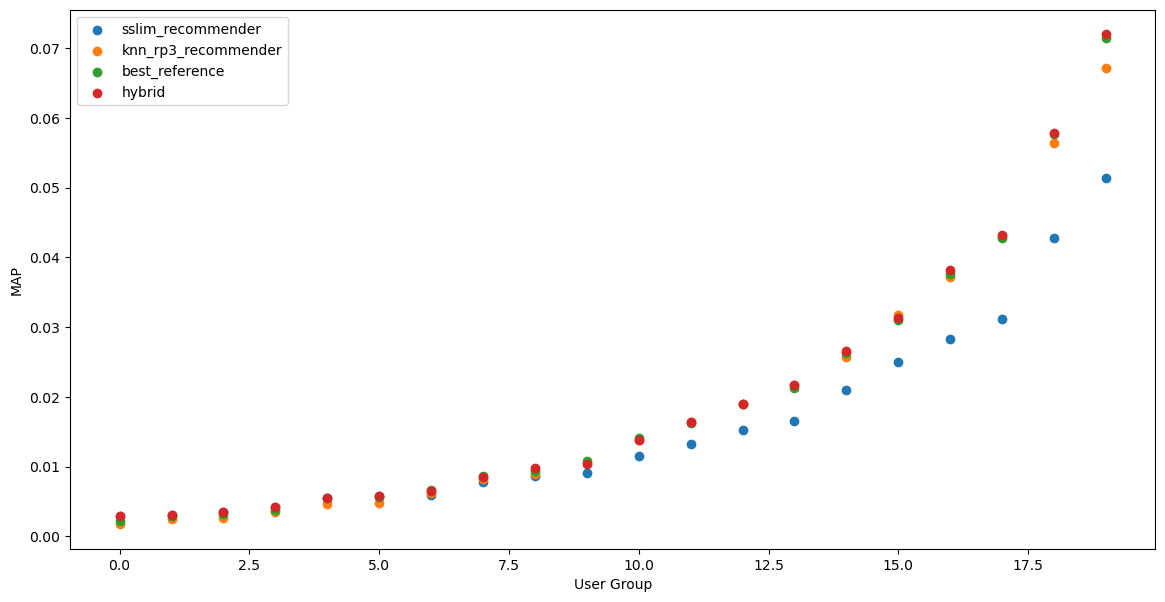

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(14, 7))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label,)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

### Evaluation

In [15]:
evaluator_test = EvaluatorHoldout(URMv_test, [10])
ris, _ = evaluator_test.evaluateRecommender(hybrid)
ris

EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 40033 (100.0%) in 27.93 sec. Users per second: 1433


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.041586,0.070656,0.066109,0.020526,0.033959,0.135353,NaN,0.051055,0.273424,0.165148,...,0.961661,0.262942,0.961661,0.019984,8.410784,0.989916,0.045697,0.625414,4.653941,0.26107


In [16]:
evaluator_test = EvaluatorHoldout(URMv_test, [10])
ris, _ = evaluator_test.evaluateRecommender(best_reference)
ris

EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 40033 (100.0%) in 12.15 sec. Users per second: 3294


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.041099,0.069824,0.065316,0.020333,0.033679,0.134733,NaN,0.050452,0.271526,0.163997,...,0.961661,0.261116,0.961661,0.047223,9.460574,0.995186,0.10802,0.703496,3.478553,0.276984
